In [11]:
import pandas as pd
import numpy as np
import random
import json

# Pricacy Tests

In [75]:
df_test_cut = pd.read_csv("../data/interim/split/sorted_test_data_mm.csv", nrows=10000)
df_train_cut = pd.read_csv(
    "../data/interim/split/sorted_train_data_mm.csv", nrows=10000
)
df_test = pd.read_csv("../data/interim/split/sorted_test_data_mm.csv")

synthetic_data_paths = [
    "../data/interim/privacy_testing/Epoch_1_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Epoch_10_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Epoch_50_synthdata_from_data_train_for_privacy.csv",
    "../data/interim/privacy_testing/Epoch_100_synthdata_from_data_train_for_privacy.csv",
]

file_names = [path.split("/")[-1].split(".")[0] for path in synthetic_data_paths]

In [76]:
synth_data_dict = {}

for path, file_name in zip(synthetic_data_paths, file_names):
    synth_data_dict[file_name] = pd.read_csv(path)

# Monte-Carlo Attack 

Hilprecht, B., Härterich, M., & Bernau, D. (2019, June 7). Reconstruction and Membership Inference Attacks against Generative Models. http://arxiv.org/pdf/1906.03006 

## Calculating the 0.1 percentile distance

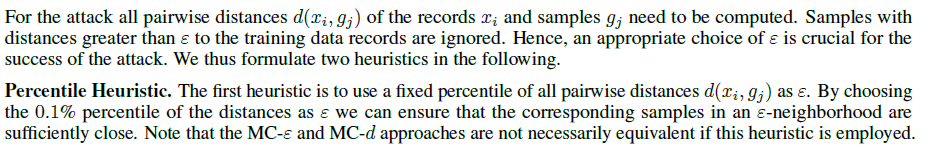

In [44]:
# for computational reasons, only some samples are taken, hence the run time in n^2.

sampled_data = synth_data_dict["synthdata_from_data_train_for_privacy"].sample(
    n=100, random_state=42
)

In [8]:
def calculate_and_print_percentile(sampled_data, df_train):

    """
    Calculate the 0.1 percentile of distances between each row of sampled_data and df_train_cut,
    and print the progress steps.

    Args:
        sampled_data (DataFrame): DataFrame containing sampled data.
        df_train_cut (DataFrame): DataFrame containing training data.

    Returns:
        float: The 0.1 percentile of distances.
    """
    a = 0
    distance_list = []

    for index, row1 in sampled_data.iterrows():
        print(f"There will be {len(sampled_data)} steps")

        a += 1
        for index, row2 in df_train.iterrows():
            distance_list.append(np.linalg.norm(row1 - row2))

        print(a)

    percentile_01 = np.percentile(distance_list, 0.1)
    print("0.1 percentile:", percentile_01)

    return percentile_01

In [10]:
perentile_dict = {}
for key in synth_data_dict:
    sample = synth_data_dict[key].sample(n=100, random_state=42)
    perentile_dict[key] = calculate_and_print_percentile(sample, df_train_cut)

There will be 100 steps
1
There will be 100 steps
2
There will be 100 steps
3
There will be 100 steps
4
There will be 100 steps
5
There will be 100 steps
6
There will be 100 steps
7
There will be 100 steps
8
There will be 100 steps
9
There will be 100 steps
10
There will be 100 steps
11
There will be 100 steps
12
There will be 100 steps
13
There will be 100 steps
14
There will be 100 steps
15
There will be 100 steps
16
There will be 100 steps
17
There will be 100 steps
18
There will be 100 steps
19
There will be 100 steps
20
There will be 100 steps
21
There will be 100 steps
22
There will be 100 steps
23
There will be 100 steps
24
There will be 100 steps
25
There will be 100 steps
26
There will be 100 steps
27
There will be 100 steps
28
There will be 100 steps
29
There will be 100 steps
30
There will be 100 steps
31
There will be 100 steps
32
There will be 100 steps
33
There will be 100 steps
34
There will be 100 steps
35
There will be 100 steps
36
There will be 100 steps
37
There will

In [12]:
with open("../data/interim/privacy_testing/percentile_dict_data", "w") as json_file:
    json.dump(perentile_dict, json_file)

print("Dictionary stored to file successfully.")

Dictionary stored to file successfully.


### Choosing the training and testing samples in order to figure out the rightly choosen train data proportion
### Single MI

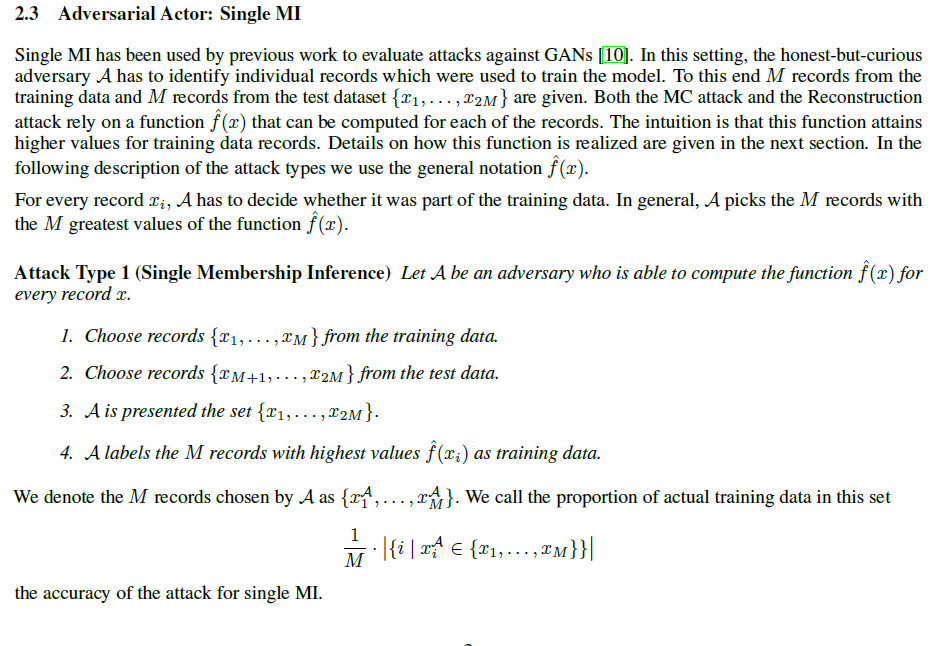

In [91]:
df_train_sample = df_train_cut.sample(
    n=10, random_state=42
)

df_test_sample = df_test.sample(
    n=10, random_state=42)

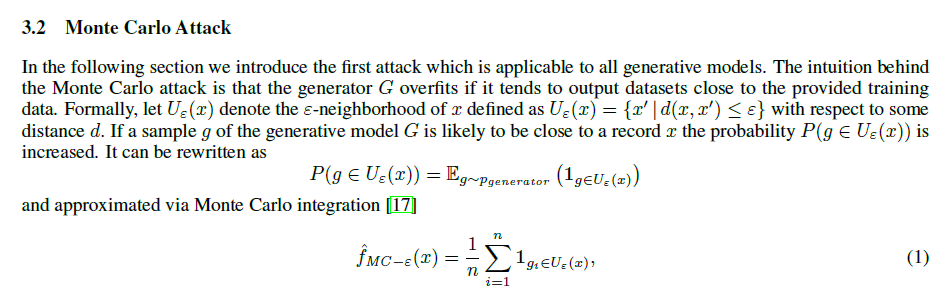

In [92]:
def calculate_distance_list(df_sample, df_original):
    """
    Calculate the euclidean distances between each row of the sample and each row of the training data.

    Args:
        df_sample (DataFrame): DataFrame containing the sample data.
        df_original (DataFrame): DataFrame containing the original (training) data.

    Returns:
        list: List containing the distances between each row of the sample and each row of the training data.
    """

    a = 0
    print(f"There will be {len(df_sample)} steps")

    distance_list = []
    for index, row1 in df_sample.iterrows():
        a += 1
        print(a)
        for index, row2 in df_original.iterrows():
            distance_list.append(np.linalg.norm(row1 - row2))

    return distance_list

### Indicator Function
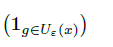

In [109]:
def indicator_function(distance_list, distance_from_dict):
    """
    This is the index function. 1 if within e-environemnt
    0 if not
    """

    return [
        1 if np.abs(distance) < 0.0879617070659176 else 0 for distance in distance_list
    ]
# 0.0879617070659176

In [110]:
def sum_of_n_steps(distance_list, lenght_original_list):

    """
    Calculate the sum of how often a row of the sample is within the €-environment.

    Args:
        distance_list (list): A list of distances between each row of the sample and
        each row of the original training data. (see calculate_distance_list)
        length_original_list (int): The length of each step.

    Returns:
        list: A list containing the sum of samples within the e-environment
        for each row of the sample data.

    """

    new_list = []
    for i in range(0, len(distance_list), lenght_original_list):
        sum_of_100 = sum(distance_list[i : i + lenght_original_list])
        
        # according to Hilprecht et al. (2019) this should be the probability. Yet it
        # However, in our case, we're dealing with the sum of many means with the same denominator.
        # Therefore, we use a value of the numerator instead of the mean value to simplify calculations.

        new_list.append(sum_of_100)
    return new_list

In [111]:
def monte_carlo_attack(df_train_original, df_train_sample, df_test_sample, distance_from_dict):

    lenght_df_train_original = len(df_train_original)

    # calculation the distance between the train data sample and the original train data
    distance_list_train = calculate_distance_list(df_train_sample, df_train_original)

    # combined index function and sum of it.
    order_train_function_list = sum_of_n_steps(
        indicator_function(distance_list_train, distance_from_dict), lenght_df_train_original
    )

    # appyling the values of f(x) to the sample and adding an identifier
    df_train_sample["function_values"] = order_train_function_list
    df_train_sample['identifier'] = 1

    # calculation the distance between the test data sample and the original train data
    distance_list_test = calculate_distance_list(
        df_test_sample, df_train_original
    )  

    # combined index function and sum of it.
    order_test_function_list = sum_of_n_steps(
        indicator_function(distance_list_test, distance_from_dict), lenght_df_train_original
    )

    # appyling the values of the f(x) to the sample and adding an identifier
    df_test_sample["function_values"] = order_test_function_list
    df_test_sample["identifier"] = 0

    df_concat = pd.concat([df_train_sample, df_test_sample], ignore_index=True)
    df_concat.sort_values(by="function_values", inplace=True, ascending=False)
    rightly_choosen_samples = sum(df_concat.head(len(df_train_sample))["identifier"])

    return df_concat, rightly_choosen_samples

In [112]:
_, rightly_choosen_samples = monte_carlo_attack(
    df_train_cut, df_train_sample, df_test_sample, 0.0879617070659176
)

There will be 10 steps
1
2
3
4
5
6
7
8
9
10
There will be 10 steps
1
2
3
4
5
6
7
8
9
10


In [115]:
rightly_choosen_samples

2

In [114]:
rightly_choosen_samples_dict = {}

for key in perentile_dict:
    _, rightly_choosen_samples = monte_carlo_attack(
        df_train_cut, df_train_sample, df_test_sample, perentile_dict[key])
    rightly_choosen_samples_dict[key] = rightly_choosen_samples

There will be 10 steps
1


KeyboardInterrupt: 

In [ ]:
rightly_choosen_samples_dict

{'Epoch_1_synthdata_from_data_train_for_privacy': 2,
 'Epoch_10_synthdata_from_data_train_for_privacy': 2,
 'Epoch_50_synthdata_from_data_train_for_privacy': 2,
 'Epoch_100_synthdata_from_data_train_for_privacy': 2}

In [ ]:
with open(
    "../data/interim/privacy_testing/rightly_choosen_samples_dict_data", "w"
) as json_file:
    json.dump(rightly_choosen_samples_dict, json_file)

print("Dictionary stored to file successfully.")

## Set Membership Inference

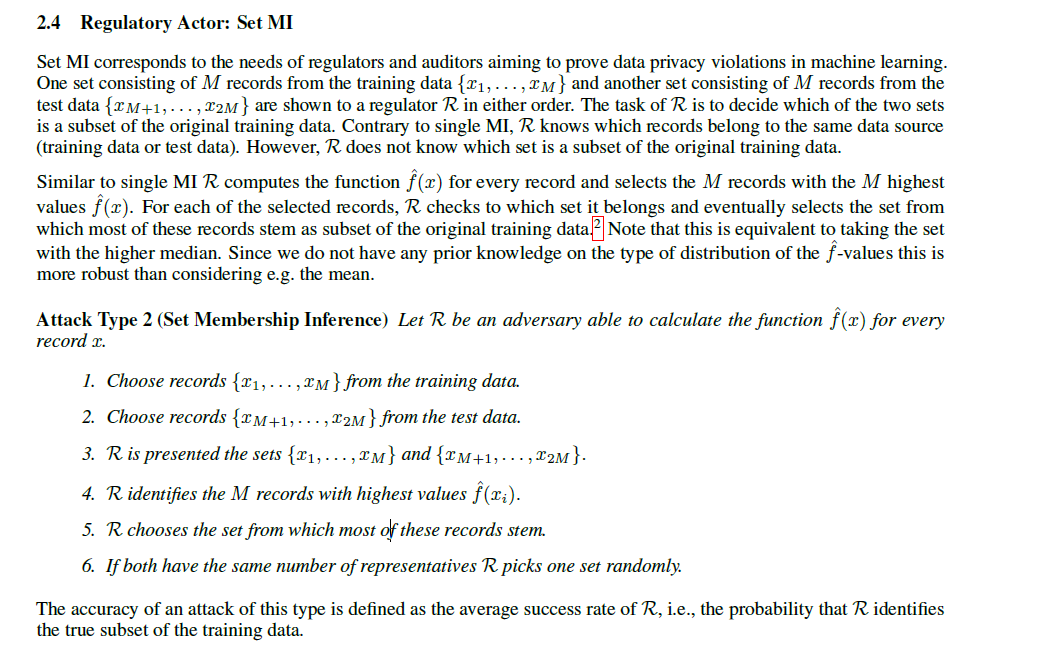

In [ ]:
#Creating of the sets

membership_sample_data_train_list = []
membership_sample_data_test_list = []

# Generate five random integers between 1 and 100 (inclusive)
random_ints = [random.randint(1, 1000) for _ in range(3)]

for i in random_ints:
    membership_sample_data_train_list.append(df_train_cut.sample(n=100, random_state=i))
    membership_sample_data_test_list.append(df_test_cut.sample(n=100, random_state=i))
    


In [ ]:
set_mi_eval = {}

for index, (train, test) in enumerate(zip(membership_sample_data_train_list, membership_sample_data_test_list)):
    _, rightly_choosen_samples = monte_carlo_attack(df_train_cut, train, test)
    set_mi_eval[index] = rightly_choosen_samples

There will be 100 steps
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
There will be 100 steps
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
There will be 100 steps
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
There will be 100 steps
1
2
3
4
5
6
7
8
9
10
11
12
1

In [ ]:
set_mi_eval

{0: 92, 1: 96, 2: 96}